## About the dataset
**In this dataset, you are presented pairs of phrases (an anchor and a target phrase) and asked to rate how similar they are on a scale from 0 (not at all similar) to 1 (identical in meaning). This challenge differs from a standard semantic similarity task in that similarity has been scored here within a patent's context, specifically its CPC classification (version 2021.05), which indicates the subject to which the patent relates. For example, while the phrases "bird" and "Cape Cod" may have low semantic similarity in normal language, the likeness of their meaning is much closer if considered in the context of "house".**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cpcc-dataset/Cooperative_Patent_Classification_Codes_Meaning.csv
/kaggle/input/us-patent-phrase-to-phrase-matching/sample_submission.csv
/kaggle/input/us-patent-phrase-to-phrase-matching/train.csv
/kaggle/input/us-patent-phrase-to-phrase-matching/test.csv


#### Importing the training dataset

In [2]:
train = pd.read_csv("../input/us-patent-phrase-to-phrase-matching/train.csv")
train.head()

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


**In this dataset, we have primarily see whether the given *target* phrase has any semantic relation to the *anchor* phase but in respect to the *context* category.**

**Importing the submission file**

In [3]:
submission = pd.read_csv("../input/us-patent-phrase-to-phrase-matching/sample_submission.csv")
submission.head()

,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [4]:
test = pd.read_csv("../input/us-patent-phrase-to-phrase-matching/test.csv")
test.head()

,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


In [5]:
# The shape of the training dataset
train.shape

(36473, 5)

In [6]:
test.shape

(36, 4)

#### Number of unique categories in the *context* feature are 106, as we can see below.

In [7]:
np.sort(train['context'].unique())

array(['A01', 'A21', 'A22', 'A23', 'A24', 'A41', 'A43', 'A44', 'A45',
       'A46', 'A47', 'A61', 'A62', 'A63', 'B01', 'B02', 'B03', 'B05',
       'B07', 'B08', 'B21', 'B22', 'B23', 'B24', 'B25', 'B27', 'B28',
       'B29', 'B31', 'B32', 'B41', 'B44', 'B60', 'B61', 'B62', 'B63',
       'B64', 'B65', 'B66', 'B67', 'B81', 'C01', 'C02', 'C03', 'C04',
       'C06', 'C07', 'C08', 'C09', 'C10', 'C11', 'C12', 'C13', 'C14',
       'C21', 'C22', 'C23', 'C25', 'D01', 'D03', 'D04', 'D05', 'D06',
       'D21', 'E01', 'E02', 'E03', 'E04', 'E05', 'E06', 'E21', 'F01',
       'F02', 'F03', 'F04', 'F15', 'F16', 'F17', 'F21', 'F22', 'F23',
       'F24', 'F25', 'F26', 'F27', 'F28', 'F41', 'F42', 'G01', 'G02',
       'G03', 'G04', 'G05', 'G06', 'G07', 'G08', 'G09', 'G10', 'G11',
       'G16', 'G21', 'H01', 'H02', 'H03', 'H04', 'H05'], dtype=object)

In [8]:
train['context'].nunique()

106

In [9]:
train['score'].unique()

array([0.5 , 0.75, 0.25, 0.  , 1.  ])

### Data preprocessing of the training dataset. 

#### Transform the *anchor* and *target* features into lowercase.

In [10]:
train['anchor'] = train['anchor'].str.lower()
train['target'] = train['target'].str.lower()

In [11]:
test['anchor'] = test['anchor'].str.lower()
test['target'] = test['target'].str.lower()

#### Removing punctuations from *anchor* and *target* features

In [12]:
train['anchor'] = train['anchor'].str.replace('[^\w\s]','',regex=True)
train['target'] = train['target'].str.replace('[^\w\s]','',regex=True)

In [13]:
test['anchor'] = test['anchor'].str.replace('[^\w\s]','',regex=True)
test['target'] = test['target'].str.replace('[^\w\s]','',regex=True)

#### Removing stopwords from *anchor* and *target* features, and creating new features *new_anchor* and  *new_target*, respectively.

In [14]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])
train['new_target'] = train['target'].apply(lambda x: remove_stopwords(x))
train['new_anchor'] = train['anchor'].apply(lambda x: remove_stopwords(x))
train.head()

,id,anchor,target,context,score,new_target,new_anchor
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,abatement pollution,abatement
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,act abating,abatement
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,active catalyst,abatement
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,eliminating process,abatement
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,forest region,abatement


In [15]:
test['new_target'] = test['target'].apply(lambda x: remove_stopwords(x))
test['new_anchor'] = test['anchor'].apply(lambda x: remove_stopwords(x))
test.head()

,id,anchor,target,context,new_target,new_anchor
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,inorganic photoconductor drum,opc drum
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,altering gas flow,adjust gas flow
2,36baf228038e314b,lower trunnion,lower locating,B60,lower locating,lower trunnion
3,1f37ead645e7f0c8,cap component,upper portion,D06,upper portion,cap component
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,artificial neural network,neural stimulation


**Analyzing further the features *new_target* and *new_anchor*.**

In [16]:
# The minimum string length in new_target and target features
print(f"The minimum string length of target feature is {train['target'].str.len().min() }, and for the new_target feature the minimum string length is {train['new_target'].str.len().min()}")
# Printing those rows which have minimum string length for the new_target feature
train[train['new_target'].str.len()==train['new_target'].str.len().min()]

The minimum string length of target feature is 2, and for the new_target feature the minimum string length is 0


,id,anchor,target,context,score,new_target,new_anchor
2460,5bda803b2cb4f929,average impact,same,G01,0.0,,average impact
3816,32880095e75a14a6,brake arms,same,F15,0.0,,brake arms
9043,bebe402021b9446f,different circumferential positions,same,G02,0.0,,different circumferential positions
17424,11f85608911d2d0f,intermediate speed,same,H04,0.0,,intermediate speed
18291,3f6592ff02cd9712,lifting load,same,B66,0.0,,lifting load
20422,7c21f880c42477c5,modify before use,after,A61,0.0,,modify use
20427,200f198a9962cbd0,modify before use,before,A61,0.0,,modify use


In [17]:
# Printing those rows which have minimum string length for the target feature
train[train['target'].str.len()==train['target'].str.len().min()]

,id,anchor,target,context,score,new_target,new_anchor
3573,341150d5bff66233,board id,id,G01,0.25,id,board id
9741,56070eacd5bfe0e2,display object,tv,G04,0.25,tv,display object
10645,f6aaca702ae77b88,el display,tv,H01,0.25,tv,el display
15476,b352c502a632f3a0,hexahydro,h6,C09,0.75,h6,hexahydro
15493,b643b4b6cd024f11,hexahydro,h6,C13,0.75,h6,hexahydro
27329,2a440ca0e1bb93f5,reflection type liquid crystal display,tv,G02,0.25,tv,reflection type liquid crystal display
33668,19eee4c71ee93b5a,transparent liquid crystal display,tv,G09,0.25,tv,transparent liquid crystal display


In [18]:
# The minimum string length in new_target and target features
print(f"The minimum string length of target feature is {test['target'].str.len().min() }, and for the new_target feature the minimum string length is {test['new_target'].str.len().min()}")
# Printing those rows which have minimum string length for the new_target feature
test[test['new_target'].str.len()==test['new_target'].str.len().min()]

The minimum string length of target feature is 7, and for the new_target feature the minimum string length is 7


,id,anchor,target,context,new_target,new_anchor
21,3ff0e7a35015be69,perfluoroalkyl group,hydroxy,A63,hydroxy,perfluoroalkyl group


In [19]:
# Printing those rows which have minimum string length for the target feature
test[test['target'].str.len()==test['target'].str.len().min()]

,id,anchor,target,context,new_target,new_anchor
21,3ff0e7a35015be69,perfluoroalkyl group,hydroxy,A63,hydroxy,perfluoroalkyl group


**The place where *new_target* is string length is equal to zero will be replaced by the corresponding *target* values. Thereafter, I drop the column *target* and rename *new_target* as *target* for sake of continuity.**

In [20]:
# Replacing those values in new_target where string length==0 by corresponding target values
train.loc[train['new_target'].str.len()== train['new_target']\
          .str.len().min(),'new_target']=train[train['new_target'].str.len()== train['new_target']\
                                                  .str.len().min()]['target']

In [21]:
# Printing those rows which have minimum string length for the new_target feature
train[train['new_target'].str.len()==train['new_target'].str.len().min()]

,id,anchor,target,context,score,new_target,new_anchor
3573,341150d5bff66233,board id,id,G01,0.25,id,board id
9741,56070eacd5bfe0e2,display object,tv,G04,0.25,tv,display object
10645,f6aaca702ae77b88,el display,tv,H01,0.25,tv,el display
15476,b352c502a632f3a0,hexahydro,h6,C09,0.75,h6,hexahydro
15493,b643b4b6cd024f11,hexahydro,h6,C13,0.75,h6,hexahydro
27329,2a440ca0e1bb93f5,reflection type liquid crystal display,tv,G02,0.25,tv,reflection type liquid crystal display
33668,19eee4c71ee93b5a,transparent liquid crystal display,tv,G09,0.25,tv,transparent liquid crystal display


In [22]:
# Dropping the target column
train = train.drop(["target"],axis=1)
train.head()

,id,anchor,context,score,new_target,new_anchor
0,37d61fd2272659b1,abatement,A47,0.50,abatement pollution,abatement
1,7b9652b17b68b7a4,abatement,A47,0.75,act abating,abatement
2,36d72442aefd8232,abatement,A47,0.25,active catalyst,abatement
3,5296b0c19e1ce60e,abatement,A47,0.50,eliminating process,abatement
4,54c1e3b9184cb5b6,abatement,A47,0.00,forest region,abatement


In [23]:
# Dropping the target column
test = test.drop(["target"],axis=1)
test.head()

,id,anchor,context,new_target,new_anchor
0,4112d61851461f60,opc drum,G02,inorganic photoconductor drum,opc drum
1,09e418c93a776564,adjust gas flow,F23,altering gas flow,adjust gas flow
2,36baf228038e314b,lower trunnion,B60,lower locating,lower trunnion
3,1f37ead645e7f0c8,cap component,D06,upper portion,cap component
4,71a5b6ad068d531f,neural stimulation,H04,artificial neural network,neural stimulation


In [24]:
# Renaming the new_target as target
train.rename(columns={"new_target":"target"}, inplace=True)
train.head()

,id,anchor,context,score,target,new_anchor
0,37d61fd2272659b1,abatement,A47,0.50,abatement pollution,abatement
1,7b9652b17b68b7a4,abatement,A47,0.75,act abating,abatement
2,36d72442aefd8232,abatement,A47,0.25,active catalyst,abatement
3,5296b0c19e1ce60e,abatement,A47,0.50,eliminating process,abatement
4,54c1e3b9184cb5b6,abatement,A47,0.00,forest region,abatement


In [25]:
# Renaming the new_target as target
test.rename(columns={"new_target":"target"}, inplace=True)
test.head()

,id,anchor,context,target,new_anchor
0,4112d61851461f60,opc drum,G02,inorganic photoconductor drum,opc drum
1,09e418c93a776564,adjust gas flow,F23,altering gas flow,adjust gas flow
2,36baf228038e314b,lower trunnion,B60,lower locating,lower trunnion
3,1f37ead645e7f0c8,cap component,D06,upper portion,cap component
4,71a5b6ad068d531f,neural stimulation,H04,artificial neural network,neural stimulation


In [26]:
# Similarly as above we observe for anchor and new_anchor feature
# The minimum string length in new_anchor and anchor features
print(f"The minimum string length of anchor feature is {train['anchor'].str.len().min() }, and for the new_anchor feature the minimum string length is {train['new_anchor'].str.len().min()}")

The minimum string length of anchor feature is 3, and for the new_anchor feature the minimum string length is 3


In the *anchor* and *new_anchor* features have same minimum string length, therefore we can directly drop the *anchor* feature and rename the *new_anchor* feature as *anchor* feature.

In [27]:
# Similarly as above we observe for anchor and new_anchor feature
# The minimum string length in new_anchor and anchor features
print(f"The minimum string length of anchor feature is {test['anchor'].str.len().min() }, and for the new_anchor feature the minimum string length is {test['new_anchor'].str.len().min()}")

The minimum string length of anchor feature is 5, and for the new_anchor feature the minimum string length is 5


In [28]:
# Dropping the anchor feature
train = train.drop(["anchor"],axis=1)
# Rename the new_anchor feature as anchor feature
train.rename(columns={"new_anchor":"anchor"}, inplace=True)
train.head()

,id,context,score,target,anchor
0,37d61fd2272659b1,A47,0.50,abatement pollution,abatement
1,7b9652b17b68b7a4,A47,0.75,act abating,abatement
2,36d72442aefd8232,A47,0.25,active catalyst,abatement
3,5296b0c19e1ce60e,A47,0.50,eliminating process,abatement
4,54c1e3b9184cb5b6,A47,0.00,forest region,abatement


In [29]:
# Dropping the anchor feature
test = test.drop(["anchor"],axis=1)
# Rename the new_anchor feature as anchor feature
test.rename(columns={"new_anchor":"anchor"}, inplace=True)
test.head()

,id,context,target,anchor
0,4112d61851461f60,G02,inorganic photoconductor drum,opc drum
1,09e418c93a776564,F23,altering gas flow,adjust gas flow
2,36baf228038e314b,B60,lower locating,lower trunnion
3,1f37ead645e7f0c8,D06,upper portion,cap component
4,71a5b6ad068d531f,H04,artificial neural network,neural stimulation


In [30]:
# Simply rearranging the columns
train = train[['id','anchor','target','context','score']]
train.head()

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


In [31]:
# Simply rearranging the columns
test = test[['id','anchor','target','context']]
test.head()

,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


#### Exploratory Data Analysis (EDA)
**Now we analyze whether there is any null elements in the dataframe**

In [32]:
train.isnull().sum()

id         0
anchor     0
target     0
context    0
score      0
dtype: int64

In [33]:
test.isnull().sum()

id         0
anchor     0
target     0
context    0
dtype: int64

#### First we analyze the *target* feature.

**Distribution of sentence length in the *target* feature**

Text(0.5, 1.0, 'Histogram of sentence length of the target feature')

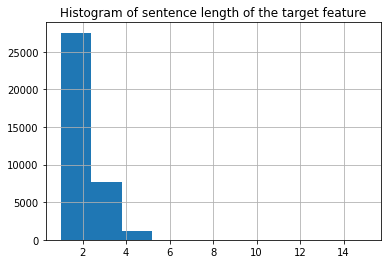

In [34]:
import matplotlib.pyplot as plt
train['target'].str.split(" ").apply(lambda x: len(x)).hist()
plt.title("Histogram of sentence length of the target feature")

In [35]:
# Distribution of number of words in a sentence of the target feature
sent_max = train['target'].str.split(" ").apply(lambda x: len(x)).max()
sent_min = train['target'].str.split(" ").apply(lambda x: len(x)).min()
print(f"The minimum and maximum sentence length in the target feature are {sent_min} and {sent_max}, respectively.")

The minimum and maximum sentence length in the target feature are 1 and 15, respectively.


**Mostly the sentence length in the *target* feature is about 2 i.e. 2 words in a sentence.**

**Distribution of character length in the *target* feature**

Text(0.5, 1.0, 'Histogram of character length of the target feature')

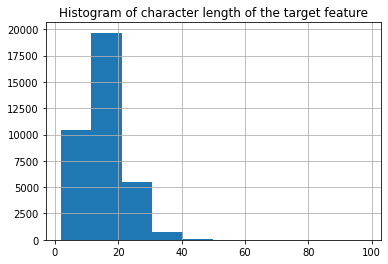

In [36]:
train['target'].str.len().hist()
plt.title("Histogram of character length of the target feature")

In [37]:
char_max = train['target'].str.len().max()
char_min = train['target'].str.len().min()
print(f"The minimum and maximum character length in the target feature are {char_min} and {char_max}, respectively.")

The minimum and maximum character length in the target feature are 2 and 98, respectively.


**Mostly the character length in the *target* feature is about 20 i.e. 20 characters in a sentence.**

**Observing the Word Cloud of the *target* feature.**

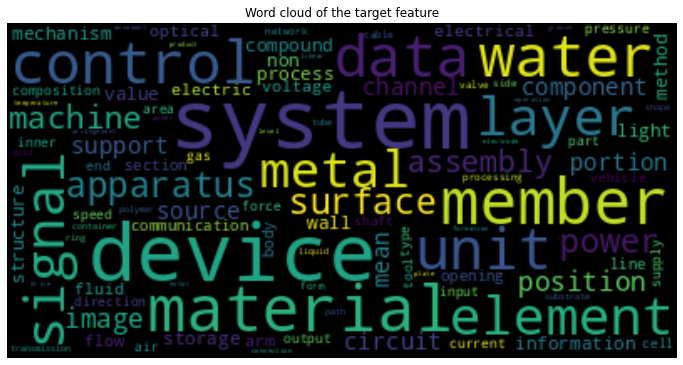

In [38]:
from wordcloud import WordCloud
# joining all the target features sentences into one line
text = " ".join(sent for sent in train.target)
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=50, max_words=100).generate(text)
# Plotting the figure
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word cloud of the target feature")
plt.show()

**Frequently occuring words in the *target* feature are *device*, *system*, *material*, *member*, etc.**

#### Now we look into the *anchor* feature.

Text(0.5, 1.0, 'Histogram of sentence length of the anchor feature')

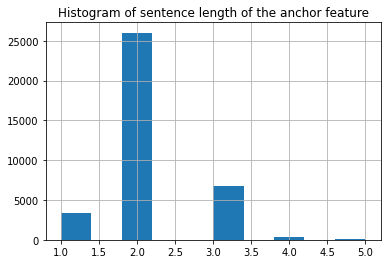

In [39]:
# Distribution of number of words in a sentence of the anchor feature
train['anchor'].str.split(" ").apply(lambda x: len(x)).hist(align='mid')
plt.title("Histogram of sentence length of the anchor feature")

In [40]:
sent_max = train['anchor'].str.split(" ").apply(lambda x: len(x)).max()
sent_min = train['anchor'].str.split(" ").apply(lambda x: len(x)).min()
print(f"The minimum and maximum sentence length in the anchor feature are {sent_min} and {sent_max}, respectively.")

The minimum and maximum sentence length in the anchor feature are 1 and 5, respectively.


**On an average the common number of words in a sentence of the *anchor* feature is 2. The minimum length is 1 and maximum length is 5.**

Text(0.5, 1.0, 'Histogram of character length of the anchor feature')

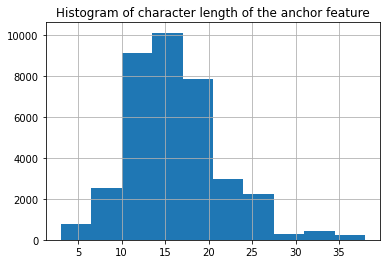

In [41]:
# Distribution of number of characters in a sentence of the anchor feature
train['anchor'].str.len().hist()
plt.title("Histogram of character length of the anchor feature")

In [42]:
char_max = train['anchor'].str.len().max()
char_min = train['anchor'].str.len().min()
print(f"The minimum and maximum character length in the anchor feature are {char_min} and {char_max}, respectively.")

The minimum and maximum character length in the anchor feature are 3 and 38, respectively.


**On an average the common number of charaters in a sentence of the *anchor* feature is in the range 10 to 20. The minimum length is 3 and maximum length is 38.**

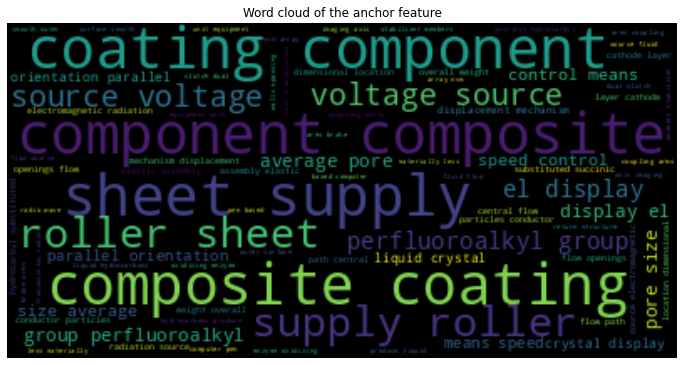

In [43]:
# joining all the target features sentences into one line
text = " ".join(sent for sent in train.anchor)
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=50, max_words=100).generate(text)
# Plotting the figure
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word cloud of the anchor feature")
plt.show()

In [44]:
np.sort(train['context'].unique())

array(['A01', 'A21', 'A22', 'A23', 'A24', 'A41', 'A43', 'A44', 'A45',
       'A46', 'A47', 'A61', 'A62', 'A63', 'B01', 'B02', 'B03', 'B05',
       'B07', 'B08', 'B21', 'B22', 'B23', 'B24', 'B25', 'B27', 'B28',
       'B29', 'B31', 'B32', 'B41', 'B44', 'B60', 'B61', 'B62', 'B63',
       'B64', 'B65', 'B66', 'B67', 'B81', 'C01', 'C02', 'C03', 'C04',
       'C06', 'C07', 'C08', 'C09', 'C10', 'C11', 'C12', 'C13', 'C14',
       'C21', 'C22', 'C23', 'C25', 'D01', 'D03', 'D04', 'D05', 'D06',
       'D21', 'E01', 'E02', 'E03', 'E04', 'E05', 'E06', 'E21', 'F01',
       'F02', 'F03', 'F04', 'F15', 'F16', 'F17', 'F21', 'F22', 'F23',
       'F24', 'F25', 'F26', 'F27', 'F28', 'F41', 'F42', 'G01', 'G02',
       'G03', 'G04', 'G05', 'G06', 'G07', 'G08', 'G09', 'G10', 'G11',
       'G16', 'G21', 'H01', 'H02', 'H03', 'H04', 'H05'], dtype=object)

#### Importing the *Cooperative Patent Classification Codes Meaning* dataset from the Kaggle notebook given [here](https://www.kaggle.com/datasets/xhlulu/cpc-codes).  

In [45]:
df_cpccm = pd.read_csv("../input/cpcc-dataset/Cooperative_Patent_Classification_Codes_Meaning.csv")
df_cpccm.head()

,code,title,section,class,subclass,group,main_group
0,A,HUMAN NECESSITIES,A,NaN,NaN,NaN,NaN
1,A01,AGRICULTURE; FORESTRY; ANIMAL HUSBANDRY; HUNTI...,A,1.0,NaN,NaN,NaN
2,A01B,SOIL WORKING IN AGRICULTURE OR FORESTRY; PARTS...,A,1.0,B,NaN,NaN
3,A01B1/00,Hand tools (edge trimmers for lawns A01G3/06 ...,A,1.0,B,1.0,0.0
4,A01B1/02,Spades; Shovels {(hand-operated dredgers E02F3...,A,1.0,B,1.0,2.0


#### Left join the *train* and the *df_cpccm* datasets

In [46]:
train = pd.merge(train, df_cpccm[["code","title"]], 
                 left_on = "context", right_on = "code",
                 how='left')

test = pd.merge(test, df_cpccm[["code","title"]], 
                 left_on = "context", right_on = "code",
                 how='left')

In [47]:
train.head()

,id,anchor,target,context,score,code,title
0,37d61fd2272659b1,abatement,abatement pollution,A47,0.50,A47,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...
1,7b9652b17b68b7a4,abatement,act abating,A47,0.75,A47,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,A47,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,A47,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,A47,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...


In [48]:
test.head()

,id,anchor,target,context,code,title
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,G02,OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,F23,COMBUSTION APPARATUS; COMBUSTION PROCESSES
2,36baf228038e314b,lower trunnion,lower locating,B60,B60,VEHICLES IN GENERAL
3,1f37ead645e7f0c8,cap component,upper portion,D06,D06,TREATMENT OF TEXTILES OR THE LIKE; LAUNDERING;...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,H04,ELECTRIC COMMUNICATION TECHNIQUE


In [49]:
train.isnull().sum()

id         0
anchor     0
target     0
context    0
score      0
code       0
title      0
dtype: int64

In [50]:
test.isnull().sum()

id         0
anchor     0
target     0
context    0
code       0
title      0
dtype: int64

#### The top 5 titles having the highest frequency 

In [51]:
train['title'].value_counts(dropna=False)[:5]

BASIC ELECTRIC ELEMENTS                                                                                                                                             2186
ELECTRIC COMMUNICATION TECHNIQUE                                                                                                                                    2177
MEASURING; TESTING                                                                                                                                                  1812
MEDICAL OR VETERINARY SCIENCE; HYGIENE                                                                                                                              1477
ENGINEERING ELEMENTS AND UNITS; GENERAL MEASURES FOR PRODUCING AND MAINTAINING EFFECTIVE FUNCTIONING OF MACHINES OR INSTALLATIONS; THERMAL INSULATION IN GENERAL    1091
Name: title, dtype: int64

In [52]:
# Saving the preprocessed dataset
train.to_csv("train_cleaned_us_patent.csv",index=False)

test.to_csv("test_cleaned_us_patent.csv",index=False)